In [1]:
# Data
import numpy as np

# if __name__ == '__main__':
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}
    
    X = [char_to_idx[x] for x in txt]
    X = np.array(X)
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
# Model
import impl.layer as l

class RNN:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(H / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))
    
    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        #         u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX

    def forward(self, X, h, m, train):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()
        X_one_hot = X.copy()
    
        X = (X_one_hot @ Wxh) + (hprev @ Whh) + bh
        h, h_cache = l.tanh_forward(X)
        
        y, y_cache = l.fc_forward(h, Why, by)

        # Dropout for training
        if train:
            y, y_do_cache = self.dropout_forward(X=y, p_dropout=self.p_dropout)
            cache = (X_one_hot, Wxh, hprev, Whh, h_cache, y_cache, y_do_cache)
        else:
            cache = (X_one_hot, Wxh, hprev, Whh, h_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        #         if train: 
        # Backward is performed for learning/training and not testing or validation.
        X_one_hot, Wxh, hprev, Whh, h_cache, y_cache, y_do_cache = cache
        dy = self.dropout_backward(dout=dy, cache=y_do_cache)

        dh_next = dh.copy()
        
        # Hidden to output gradient
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        # tanh
        dX_one_hot = l.tanh_backward(dh, h_cache)

        # Hidden gradient
        dbh = dX_one_hot * 1.0
        dWhh = hprev.T @ dX_one_hot
        dWxh = X_one_hot.T @ dX_one_hot
        
        dX = dX_one_hot @ Wxh.T
        dh = dX_one_hot @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy() # the output for the previous layer is the input for the next layer
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t]) # train=True
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy() # The input for the next layer is the output for the previous layer
            dXs.append(dX)
            
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    eps = 1e-8
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):

        # No full batch or files
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
    
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100)
            print(sample)
            
    return nn

Iter-1000 loss: 4.8588
craite tand noevo ntittlit tericentiss rym in mstreg. rcoworusko-mamandit res anountiyelSrg lurekt us
Iter-2000 loss: 6.7332
casi edean  ee the Eu iat and eses ury "9 ha as map G8, and on simenathineilo1935 aotvekt is an iast 
Iter-3000 loss: 2.8752
casi ee amist ans thx t ietounhuo us aur d T8. itithan erectreon putrrcgsothe nixsta enati iterthi Ec
Iter-4000 loss: 2.6558
ccite nertert inf neritd wurut  ims redthe fircon mama Gre tevelipcrcelied, ws sS art terctsinch hat 
Iter-5000 loss: 2.5364
cins iod t rld ant e ren eo penou an日, the wteste wertt cin tiei s theto narinstary irghtr emPted n t
Iter-6000 loss: 2.5909
constitution ingcoe ecoloma, wot 日本 Nh lo ncry, the et hul iampat  ivins Jacan paleed endEd stied ih 
Iter-7000 loss: 2.4690
ch includes rhentean Olimprop endite ihi ontu Tiegsel ogen, ane ha mee the icl teetrly in torporthe W
Iter-8000 loss: 2.5145
creclit ligite es erelirinh oast e pin ingren Estvrostare Uarloc ane oh io peotha, share emrcinita ie


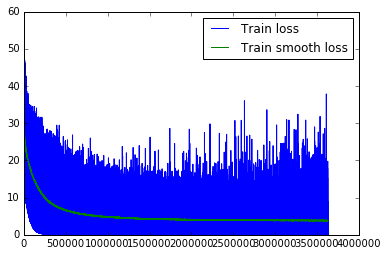

In [5]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 10000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = RNN(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()

plt.show()